- [Lab: 7.8.1 Polynomial Regression and Step Functions](#7.8.1-Polynomial-Regression-and-Step-Functions)
- [Lab: 7.8.2 Splines](#7.8.2-Splines)

# Chapter 7 - Moving Beyond Linearity

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

### Load dataset
Using write.csv in R, I exported the dataset from package 'ISLR' to a csv file.

In [2]:
df = pd.read_csv('Data/Wage.csv')
df.head(3)

   Unnamed: 0  year  age      sex            maritl      race  \
0      231655  2006   18  1. Male  1. Never Married  1. White   
1       86582  2004   24  1. Male  1. Never Married  1. White   
2      161300  2003   45  1. Male        2. Married  1. White   

         education              region        jobclass          health  \
0     1. < HS Grad  2. Middle Atlantic   1. Industrial       1. <=Good   
1  4. College Grad  2. Middle Atlantic  2. Information  2. >=Very Good   
2  3. Some College  2. Middle Atlantic   1. Industrial       1. <=Good   

  health_ins   logwage        wage  
0      2. No  4.318063   75.043154  
1      2. No  4.255273   70.476020  
2     1. Yes  4.875061  130.982177  

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
Unnamed: 0    3000 non-null int64
year          3000 non-null int64
age           3000 non-null int64
sex           3000 non-null object
maritl        3000 non-null object
race          3000 non-null object
education     3000 non-null object
region        3000 non-null object
jobclass      3000 non-null object
health        3000 non-null object
health_ins    3000 non-null object
logwage       3000 non-null float64
wage          3000 non-null float64
dtypes: float64(2), int64(3), object(8)
memory usage: 304.8+ KB


## Lab

### 7.8.1 Polynomial Regression and Step Functions

Create polynomials for 'age'. These correspond to those in R, when using raw=TRUE in poly() function.

In [4]:
X1 = PolynomialFeatures(1).fit_transform(df.age.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.reshape(-1,1))

y = (df.wage > 250).map({False:0, True:1}).as_matrix()
print('X4:\n', X4[:5])
print('y:\n', y[:5])

X4:
 [[  1.00000000e+00   1.80000000e+01   3.24000000e+02   5.83200000e+03
    1.04976000e+05]
 [  1.00000000e+00   2.40000000e+01   5.76000000e+02   1.38240000e+04
    3.31776000e+05]
 [  1.00000000e+00   4.50000000e+01   2.02500000e+03   9.11250000e+04
    4.10062500e+06]
 [  1.00000000e+00   4.30000000e+01   1.84900000e+03   7.95070000e+04
    3.41880100e+06]
 [  1.00000000e+00   5.00000000e+01   2.50000000e+03   1.25000000e+05
    6.25000000e+06]]
y:
 [0 0 0 0 0]


#### Linear regression model. (Degree 4)

In [5]:
fit2 = sm.GLS(df.wage, X4).fit()
fit2.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
const,-184.1542,60.040,-3.067,0.002,-301.879 -66.430
x1,21.2455,5.887,3.609,0.000,9.703 32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968 -0.160
x3,0.0068,0.003,2.221,0.026,0.001 0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05 1.45e-07


Selecting a suitable degree for the polynomial of age.

In [6]:
fit_1 = fit = sm.GLS(df.wage, X1).fit()
fit_2 = fit = sm.GLS(df.wage, X2).fit()
fit_3 = fit = sm.GLS(df.wage, X3).fit()
fit_4 = fit = sm.GLS(df.wage, X4).fit()
fit_5 = fit = sm.GLS(df.wage, X5).fit()

sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1)

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01

The polynomial degree 4 seems best.

In [7]:
X = X4

Scikit-learn implements a regularized logistic regression model particularly suitable for high dimensional data. Since we just have one feature (age) we use the GLM model from statsmodels.

In [8]:
clf = sm.GLM(y, X, family=sm.families.Binomial(sm.families.links.logit))
res = clf.fit()

Create array of test data. Transform to polynomial degree 4 and run prediction.

In [9]:
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

In [10]:
X_test = PolynomialFeatures(4).fit_transform(age_grid)
pred = res.predict(X_test)

### Figure 7.1

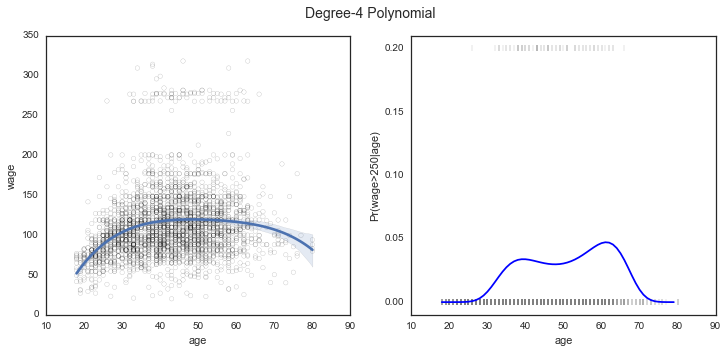

In [11]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
sns.regplot(df.age, df.wage, order = 4, truncate=True, scatter=False, ax=ax1)
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, pred, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

#### Step function

In [12]:
df_cut, bins = pd.cut(df.age, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49]        1399
(49, 64.5]         779
(64.5, 80]          72
Name: age, dtype: int64

In [13]:
df_steps = pd.concat([df.age, df_cut, df.wage], keys=['age','age_cuts','wage'], axis=1)
df_steps.head(5)

   age        age_cuts        wage
0   18  (17.938, 33.5]   75.043154
1   24  (17.938, 33.5]   70.476020
2   45      (33.5, 49]  130.982177
3   43      (33.5, 49]  154.685293
4   50      (49, 64.5]   75.043154

In [14]:
# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

df_steps_dummies.head(5)

   const  (17.938, 33.5]  (33.5, 49]  (49, 64.5]  (64.5, 80]
0      1             1.0         0.0         0.0         0.0
1      1             1.0         0.0         0.0         0.0
2      1             0.0         1.0         0.0         0.0
3      1             0.0         1.0         0.0         0.0
4      1             0.0         0.0         1.0         0.0

In [15]:
# Using statsmodels because it has a more complete output for coefficients
fit3 = sm.GLM(df_steps.wage, df_steps_dummies.drop(['(17.938, 33.5]'], axis=1)).fit()
fit3.summary().tables[1]

,coef,std err,z,P>|z|,[95.0% Conf. Int.]
const,94.1584,1.476,63.790,0.000,91.265 97.051
"(33.5, 49]",24.0535,1.829,13.148,0.000,20.468 27.639
"(49, 64.5]",23.6646,2.068,11.443,0.000,19.611 27.718
"(64.5, 80]",7.6406,4.987,1.532,0.126,-2.135 17.416


In [16]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)
bin_mapping

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [17]:
# Get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis=1))
X_test2.head()

   const    2    3    4
0      1  0.0  0.0  0.0
1      1  0.0  0.0  0.0
2      1  0.0  0.0  0.0
3      1  0.0  0.0  0.0
4      1  0.0  0.0  0.0

#### Linear Regression

In [18]:
pred2 = fit3.predict(X_test2)

#### Logistic Regression

In [19]:
clf2 = sm.GLM(y, df_steps_dummies.drop(['(17.938, 33.5]'], axis=1),
              family=sm.families.Binomial(sm.families.links.logit))
res2 = clf2.fit()
pred3 = res2.predict(X_test2)

### Figure 7.2

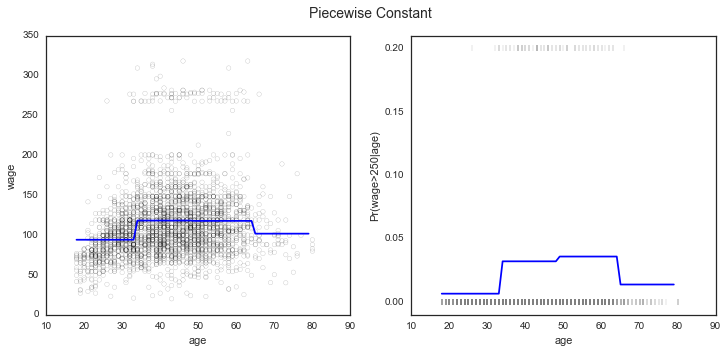

In [20]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Piecewise Constant', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, pred2, c='b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

### 7.8.2 Splines

Using patsy to create non-linear transformations of the input data. See http://patsy.readthedocs.org/en/latest/ <BR>
I have not found functions to create smoothing splines or GAMs or do local regression.

#### Cubic splines

In [21]:
# Specifying 3 knots
transformed_x = dmatrix("bs(df.age, knots=(25,40,60), degree=3, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')
fit4 = sm.GLM(df.wage, transformed_x).fit()
pred4 = fit4.predict(dmatrix("bs(age_grid, knots=(25,40,60), degree=3, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
fit4.params

Intercept                                                               60.493714
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.980500
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.630980
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.838788
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.990830
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.688098
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.606142
dtype: float64

In [22]:
# Specifying 6 degrees of freedom 
transformed_x2 = dmatrix("bs(df.age, df=6, degree=3, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')
fit5 = sm.GLM(df.wage, transformed_x2).fit()
pred5 = fit5.predict(dmatrix("bs(age_grid, df=6, degree=3, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
fit5.params

Intercept                                                 56.313841
bs(df.age, df=6, degree=3, include_intercept=False)[0]    27.824002
bs(df.age, df=6, degree=3, include_intercept=False)[1]    54.062546
bs(df.age, df=6, degree=3, include_intercept=False)[2]    65.828391
bs(df.age, df=6, degree=3, include_intercept=False)[3]    55.812734
bs(df.age, df=6, degree=3, include_intercept=False)[4]    72.131473
bs(df.age, df=6, degree=3, include_intercept=False)[5]    14.750876
dtype: float64

#### Natural splines

In [23]:
# Specifying 4 degrees of freedom
transformed_x3 = dmatrix("cr(df.age, df=4)", {"df.age": df.age}, return_type='dataframe')
fit6 = sm.GLM(df.wage, transformed_x3).fit()
pred6 = fit6.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))
fit6.params

Intercept              79.642095
cr(df.age, df=4)[0]   -14.667784
cr(df.age, df=4)[1]    36.811142
cr(df.age, df=4)[2]    35.934874
cr(df.age, df=4)[3]    21.563863
dtype: float64

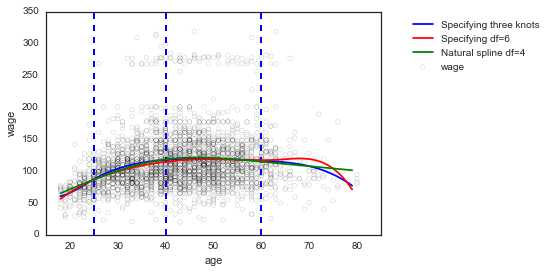

In [24]:
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(age_grid, pred4, color='b', label='Specifying three knots')
plt.plot(age_grid, pred5, color='r', label='Specifying df=6')
plt.plot(age_grid, pred6, color='g', label='Natural spline df=4')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage');